In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
user_engagement = pd.read_csv('../takehome_user_engagement.csv', encoding='latin-1')
users = pd.read_csv('../takehome_users.csv', encoding='latin-1')

In [3]:
user_engagement.head(100)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
95,2013-07-30 22:08:03,10,1
96,2013-08-02 22:08:03,10,1
97,2013-08-03 22:08:03,10,1
98,2013-08-04 22:08:03,10,1


In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
# look for any NA values
for column in users.columns:
    print(users[column].isna().value_counts())

False    12000
Name: object_id, dtype: int64
False    12000
Name: creation_time, dtype: int64
False    12000
Name: name, dtype: int64
False    12000
Name: email, dtype: int64
False    12000
Name: creation_source, dtype: int64
False    8823
True     3177
Name: last_session_creation_time, dtype: int64
False    12000
Name: opted_in_to_mailing_list, dtype: int64
False    12000
Name: enabled_for_marketing_drip, dtype: int64
False    12000
Name: org_id, dtype: int64
False    6417
True     5583
Name: invited_by_user_id, dtype: int64


In [6]:
# dropping users who have not logged in ever
users.dropna(subset=['last_session_creation_time'], inplace=True)

In [7]:
# make a new bool feature for if user was invited by another user
users.loc[users['invited_by_user_id'].isna() == True, 'invited_by_user_bool'] = False
users.loc[users['invited_by_user_id'].isna() == False, 'invited_by_user_bool'] = True
# if user was not invited by another user then assign them to user 0
users.loc[users['invited_by_user_id'].isna() == True, 'invited_by_user_id'] = 0

In [8]:
for column in users.columns:
    print(users[column].isna().value_counts())

False    8823
Name: object_id, dtype: int64
False    8823
Name: creation_time, dtype: int64
False    8823
Name: name, dtype: int64
False    8823
Name: email, dtype: int64
False    8823
Name: creation_source, dtype: int64
False    8823
Name: last_session_creation_time, dtype: int64
False    8823
Name: opted_in_to_mailing_list, dtype: int64
False    8823
Name: enabled_for_marketing_drip, dtype: int64
False    8823
Name: org_id, dtype: int64
False    8823
Name: invited_by_user_id, dtype: int64
False    8823
Name: invited_by_user_bool, dtype: int64


In [9]:
import datetime

#set the time_stamp to datetime and the set it as the index
user_engagement.time_stamp = pd.to_datetime(user_engagement.time_stamp)
user_engagement = user_engagement.set_index('time_stamp', drop= True)

In [10]:
# creating a method that can determine if a user is an adopted user.
from datetime import timedelta

def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = user_engagement.loc[user_engagement['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [11]:
#apply adopted user function to all users
users['adopted_user'] = users['object_id'].apply(label_adopted)


In [12]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user_bool,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,True,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,True,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,True,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,True,0


In [13]:
# find the ratio of adopted users to non-adopted users
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.18769126147568854


In [14]:
# engineer a new feature that the time the user has been active on the platform
users.creation_time = pd.to_datetime(users.creation_time)
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

In [15]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
#subtract to find time active
users['usage_length'] = users['last_session_creation_time'] - users['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
users['usage_length'] = [x.total_seconds() for x in users['usage_length']]

In [16]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user_bool,adopted_user,usage_length
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 20:53:30,1,0,11,10803.0,True,0,-25200.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 20:45:04,0,0,1,316.0,True,1,11725200.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 16:14:52,0,0,94,1525.0,True,0,-25200.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 01:09:28,0,0,1,5151.0,True,0,61200.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 02:14:20,0,0,193,5240.0,True,0,403200.0


In [17]:
users = users.drop(['last_session_creation_time', 'object_id', 'creation_time', 'name', 'email'], axis=1)
users['usage_length'] = users['usage_length'].fillna(0)

In [18]:
users.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,invited_by_user_bool,adopted_user,usage_length
0,GUEST_INVITE,1,0,11,10803.0,True,0,-25200.0
1,ORG_INVITE,0,0,1,316.0,True,1,11725200.0
2,ORG_INVITE,0,0,94,1525.0,True,0,-25200.0
3,GUEST_INVITE,0,0,1,5151.0,True,0,61200.0
4,GUEST_INVITE,0,0,193,5240.0,True,0,403200.0


In [19]:
# one hot encode any categorical data
creation_one_hot = pd.get_dummies(users['creation_source'], prefix='csource')
org_one_hot = pd.get_dummies(users['org_id'], prefix='org')


In [20]:
for source in creation_one_hot:
    users[source] = creation_one_hot[source]

users.drop('creation_source', axis=1, inplace=True)

for org in org_one_hot:
    users[org] = org_one_hot[org]

users.drop('org_id', axis=1, inplace=True)

In [21]:
users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,invited_by_user_bool,adopted_user,usage_length,csource_GUEST_INVITE,csource_ORG_INVITE,csource_PERSONAL_PROJECTS,csource_SIGNUP,...,org_407,org_408,org_409,org_410,org_411,org_412,org_413,org_414,org_415,org_416
0,1,0,10803.0,True,0,-25200.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,316.0,True,1,11725200.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1525.0,True,0,-25200.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,5151.0,True,0,61200.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,5240.0,True,0,403200.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
users.usage_length.value_counts()

-25200.0       2023
 61200.0       1071
-28800.0       1004
 57600.0        546
 147600.0       541
               ... 
 28054800.0       1
 27536400.0       1
 4032000.0        1
 19674000.0       1
 20448000.0       1
Name: usage_length, Length: 645, dtype: int64

In [23]:
labels = users['adopted_user']

users.drop('adopted_user', axis=1, inplace=True)


In [24]:
labels.head()

0    0
1    1
2    0
3    0
4    0
Name: adopted_user, dtype: int64

In [47]:
labels.head()

0    0
1    1
2    0
3    0
4    0
Name: adopted_user, dtype: int64

In [25]:
users.shape

(8823, 427)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(users, labels, test_size=0.33, random_state=42)

In [27]:
X_train.shape

(5911, 427)

In [28]:
X_train.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,invited_by_user_bool,usage_length,csource_GUEST_INVITE,csource_ORG_INVITE,csource_PERSONAL_PROJECTS,csource_SIGNUP,csource_SIGNUP_GOOGLE_AUTH,...,org_407,org_408,org_409,org_410,org_411,org_412,org_413,org_414,org_415,org_416
3859,0,0,8461.0,True,234000.0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3471,1,1,0.0,False,-25200.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7838,1,0,7372.0,True,15958800.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8900,0,0,10039.0,True,-28800.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3476,0,0,0.0,False,-25200.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
X_test.shape

(2912, 427)

In [30]:
X_test.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,invited_by_user_bool,usage_length,csource_GUEST_INVITE,csource_ORG_INVITE,csource_PERSONAL_PROJECTS,csource_SIGNUP,csource_SIGNUP_GOOGLE_AUTH,...,org_407,org_408,org_409,org_410,org_411,org_412,org_413,org_414,org_415,org_416
7736,1,1,0.0,False,61200.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9282,1,0,7973.0,True,-25200.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6272,0,0,0.0,False,-25200.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7527,0,0,0.0,False,61200.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1071,0,0,0.0,False,43520400.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
y_train.shape

(5911,)

In [32]:
y_train.head()

3859    0
3471    0
7838    1
8900    0
3476    0
Name: adopted_user, dtype: int64

In [33]:
y_test.shape

(2912,)

A random forest classifier was chosen as the model for its easy of use, relatively small training time, accuracy, and model explainability.

In [39]:
#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, y_train)

rf.score(X_test, y_test)
y_pred = rf.predict(X_test)

In [40]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[2315   40]
 [  74  483]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2355
           1       0.92      0.87      0.89       557

    accuracy                           0.96      2912
   macro avg       0.95      0.93      0.94      2912
weighted avg       0.96      0.96      0.96      2912

0.9608516483516484


In [42]:
users = users.columns
importances = rf.feature_importances_

In [43]:
for i in range(0, len(users)):
    print(users[i] + ': ' + str(importances[i]))

opted_in_to_mailing_list: 0.005899504467016828
enabled_for_marketing_drip: 0.0044171576203332905
invited_by_user_id: 0.022225042414811474
invited_by_user_bool: 0.0020199718831489214
usage_length: 0.7932554411104816
csource_GUEST_INVITE: 0.0033192571390415217
csource_ORG_INVITE: 0.0029932312407013315
csource_PERSONAL_PROJECTS: 0.002031134792384423
csource_SIGNUP: 0.003151975489531412
csource_SIGNUP_GOOGLE_AUTH: 0.0022748866581923316
org_0: 0.005700251411047914
org_1: 0.0015831828234751104
org_2: 0.0020568729965049436
org_3: 0.0012456399514736863
org_4: 0.0012561550489814948
org_5: 0.0010158895601460572
org_6: 0.0013462521033189433
org_7: 0.0006097842342303413
org_8: 0.000860412988812768
org_9: 0.0010060617353303907
org_10: 0.0006588630545567041
org_11: 0.000684739323415863
org_12: 0.0006958919114681546
org_13: 0.0007192596706094059
org_14: 0.0006858033776291349
org_15: 0.0007813276794926268
org_16: 0.0003522670768626418
org_17: 0.0005014168783668403
org_18: 0.0004272129730896801
org_19:

In [45]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(users)
feature_importance.coef.nlargest(10)

usage_length                  0.793255
invited_by_user_id            0.022225
opted_in_to_mailing_list      0.005900
org_0                         0.005700
enabled_for_marketing_drip    0.004417
csource_GUEST_INVITE          0.003319
csource_SIGNUP                0.003152
csource_ORG_INVITE            0.002993
csource_SIGNUP_GOOGLE_AUTH    0.002275
org_2                         0.002057
Name: coef, dtype: float64

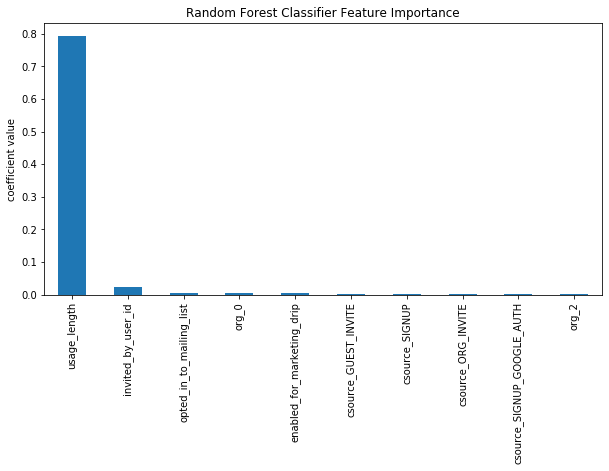

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

It can cleary be shown from the feature importances that the usage time of the user was the prominent factor in determining whether or not they became an adopted user.